<a href="https://colab.research.google.com/github/Samir-atra/BDSD_Minor_Project/blob/main/MediaPipe_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# Download and install packages
# !python -m pip install mediapipe
# !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
# !wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# Imports
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib
# from google.colab.patches import cv2_imshow
import csv
import pandas as pd
import tensorflow as tf
import keras_tuner
import math
import time
import os

In [49]:
# MediaPipe visualizations


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()


In [50]:
# a function to write to csv files
def csv_writer(filename, fields, data):

    csvfile = filename
    fields = fields
    with open(csvfile, mode="a") as first:
        csvwriter = csv.writer(first)
        csvwriter.writerow(fields)
        csvwriter.writerows(data)

        return True

In [51]:
# download and upload images
# download
# img = cv2.imread("images.jpg")
# cv2_imshow(img)

#upload
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

In [52]:
#inferencing and visualizing

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
# print(detection_result.facial_transformation_matrixes)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# img = plt.imshow(annotated_image)
# plt.show()
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

I0000 00:00:1714951032.497519  124846 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1714951032.497747  124846 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
libEGL 

In [53]:
# plot bar graphs

# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# print(detection_result.face_blendshapes[0])

In [54]:
# # Processing, cleaning and visualizing the fer2023 dataset

# dataset = []
# Training_set = []
# validation_set = []
# test_set = []
# categories_count = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}
# skipped = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}
# z_count = 0
# o_count = 0
# t_count = 0

# with open("fer2013.csv", mode= "r") as data:
#   csvFile = csv.reader(data)
#   next(csvFile)
#   for lines in csvFile:
#       if lines[0] == "0" and skipped['0'] < 1500:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '1'
#         dataset.append(lines)
#       elif lines[0] == "1" and skipped['1'] < 1500:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '1'
#         dataset.append(lines)
#       elif lines[0] == '2' and skipped['2'] < 1500:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '1'
#         dataset.append(lines) 
#       elif lines[0] == '3' and skipped['3'] < 4000:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '0'
#         dataset.append(lines) 
#       elif lines[0] == '4' and skipped['4'] < 4000:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '2'
#         dataset.append(lines) 
#       elif lines[0] == '5' and skipped['5'] < 1500:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '1'
#         dataset.append(lines) 
#       elif lines[0] == '6' and skipped['6'] < 1500:
#         skipped[lines[0]] = skipped[lines[0]] + 1
#         lines[0] = '1'
#         dataset.append(lines) 
          
  # print(dataset[1:6])
  # # iterate over the training dataset
  # for i in range(len(dataset)):
  #   if categories_count[str(dataset[i][33])] == 7500:
  #     continue
  #   else:
  #     print(categories_count[dataset[i][0]])
  #     categories_count[str(dataset[i][33])] = categories_count[str(dataset[i][33])] + 1
  #   image = np.array(Training_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
  #   image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  #   print(image.shape)
  #   rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
  #   detection_result = detector.detect(rgb_frame)
  #   print("emotion = ", Training_set[i][0])
  #   img = plt.imshow(image)
  #   plt.show()
  #   # Skip and delete the image if not understood by mediapipe
  #   if detection_result.face_blendshapes == []:
  #     skipped[Training_set[i][0]] = skipped[Training_set[i][0]] + 1
  #   else:
  #     img = plt.imshow(image)
  #     plt.show()
  #     continue

  # print("This is categories count", categories_count)
  # print("This is skipped", skipped)
  # print(dataset[:5])

# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



In [55]:
# cleaning the dataset

# training_set = []
# validation_set = []
# test_set = []

# for i in dataset:
#     if i[2] == 'Training':
#         training_set.append(i)
#     elif i[2] == 'PublicTest':
#         validation_set.append(i)
#     elif i[2] == 'PrivateTest':
#         test_set.append(i)

# training_set_hns = []
# validation_set_hns = []
# test_set_hns = []

# for lines in training_set:
#       image = np.array(lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
#       detection_result = detector.detect(frame)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         training_set_hns.append(lines)

# for liness in validation_set:
#       imagee = np.array(liness[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       imagee = cv2.cvtColor(imagee, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       framee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imagee)
#       detection_result = detector.detect(framee)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         validation_set_hns.append(liness)

# for linesss in test_set:
#       imageee = np.array(linesss[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       imageee = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       frameee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imageee)
#       detection_result = detector.detect(frameee)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         test_set_hns.append(linesss)

# fields = ["emotion", "pixels", "Usage"]
# csv_writer("training_set_full.csv", fields, training_set_hns)
# csv_writer("validation_set_full.csv", fields, validation_set_hns)
# csv_writer("test_set_full.csv", fields, test_set_hns)


In [56]:
# Augmenting images


# augmented_training_set = []
# training_images = []
# training_labels = []
# print(len(Training_set))

# for i in range(math.floor(len(training_set_hns))):
#     image = np.array(training_set_hns[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     training_images.append(image)
#     training_labels.append(int(training_set_hns[i][0]))


# # rescaling and augmenting images models
# rescaling1 = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255)
# ])

# rescaling2 = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1.*255)
# ])

# augment = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.1)
# ])

# for ele in range(len(training_images)):
# # scale down the image and augment
#   img = training_images[ele]
#   label = training_labels[ele]
#   image = rescaling1(img)
#   aug_image = augment(image)
# #   scale up the image cast to an integer and transform into a numpy array
#   aug_image = rescaling2(aug_image)
#   aug_image = tf.cast(aug_image, tf.uint8)
#   aug_image = np.array(aug_image)
#   flatten_image = aug_image.flatten()
#   flat_aug_image = [flatten_image[i] for i in range(0,len(flatten_image),3)]
#   # flattt = np.reshape(flat_aug_image,(48,48))
#   # plt.imshow(flattt)
#   # plt.show()
#   frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
#   detection_result = detector.detect(frame)
#   if detection_result.face_blendshapes == []:
#     continue
#   else:
#     element = [training_labels[ele]]
#     for i in flat_aug_image:
#       element.append(i)
#     augmented_training_set.append([element[0],str(element[1:]).replace(',',"").replace('[','').replace(']',''),'Training'])

# csv_writer("training_set_full.csv", ['emotion','pixels'], augmented_training_set)

# print(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# plt.imshow(annotated_image)
# plt.show()



In [57]:
# choosing relevant blendshapes
# blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '30', '31', '34', '35', '36', '37', '38', '40', '42', '44', '45', '46', '47', '48', '49', 'emotion']

# blend_shapes = dict()
# for i in range(0,52):
#     blend_shapes[str(i)] = 0

# print(blend_shapes)
# sad = 0
# happy = 0
# counter = 0

#   # find which blendshapes are most relevant to happiness and sadness
# for i in range(len(training_set_hns)):
#     image = np.array(training_set_hns[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
#     detection_result = detector.detect(frame)
#     if detection_result.face_blendshapes == []:
#         continue
#     else:
#         counter += 1
#     if counter %500 == 0:
#         time.sleep(5)
#     for i in detection_result.face_blendshapes[0]:
#         if i.score > 0.4:
#             blend_shapes[str(i.index)] = blend_shapes[str(i.index)] + 1
# print(blend_shapes)

# # detect annotate and plot blendshapes for the image
# frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
# detection_result = detector.detect(frame)
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [58]:
# if-else classification

# if detection_result.face_blendshapes[0][44].score > 0.5 and detection_result.face_blendshapes[0][45].score > 0.5 :
#   print("Happy")
# elif detection_result.face_blendshapes[0][42].score > 0.5:
#   print("Sad")


In [59]:
# creating blendshapes dataset

# test_set = []
# test_images = []
# test_labels = []

# # blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '30', '31', '34', '35', '36', '37', '38', '40', '42', '44', '45', '46', '47', '48', '49','999']
# with open("validation_set_full.csv", mode= "r") as data:
#   csvFile = csv.reader(data)
#   next(csvFile)
#   for lines in csvFile:
#     test_set.append(lines)
# #   print(test_set[0])
#   for i in range(len(test_set)):
#     # print(training_set[i][1])
#     image = np.array(test_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     test_images.append(image)
#     test_labels.append(int(test_set[i][0]))

# arr = np.zeros((len(test_images), 53))

# print(len(test_images))
# # arr[0,:]= blendS_to_print
# for ele in range(len(test_images)-1):
#   img = test_images[ele]
#   label = test_labels[ele]
#   frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=img)
#   detection_result = detector.detect(frame)
#   # print(detection_result.face_blendshapes[0])
#   for category in detection_result.face_blendshapes[0]:
#     # if str(category.index) in blendS_to_print:
#        arr[ele, category.index] = category.score
#        arr[ele, 52] = label
#     # else:
#     #    continue
# print(arr[2])
# arr = np.around(arr, 4)
# print(arr[2])

# np.savetxt("blends_val_full_set.csv", arr, delimiter = ",", fmt="%.4f")

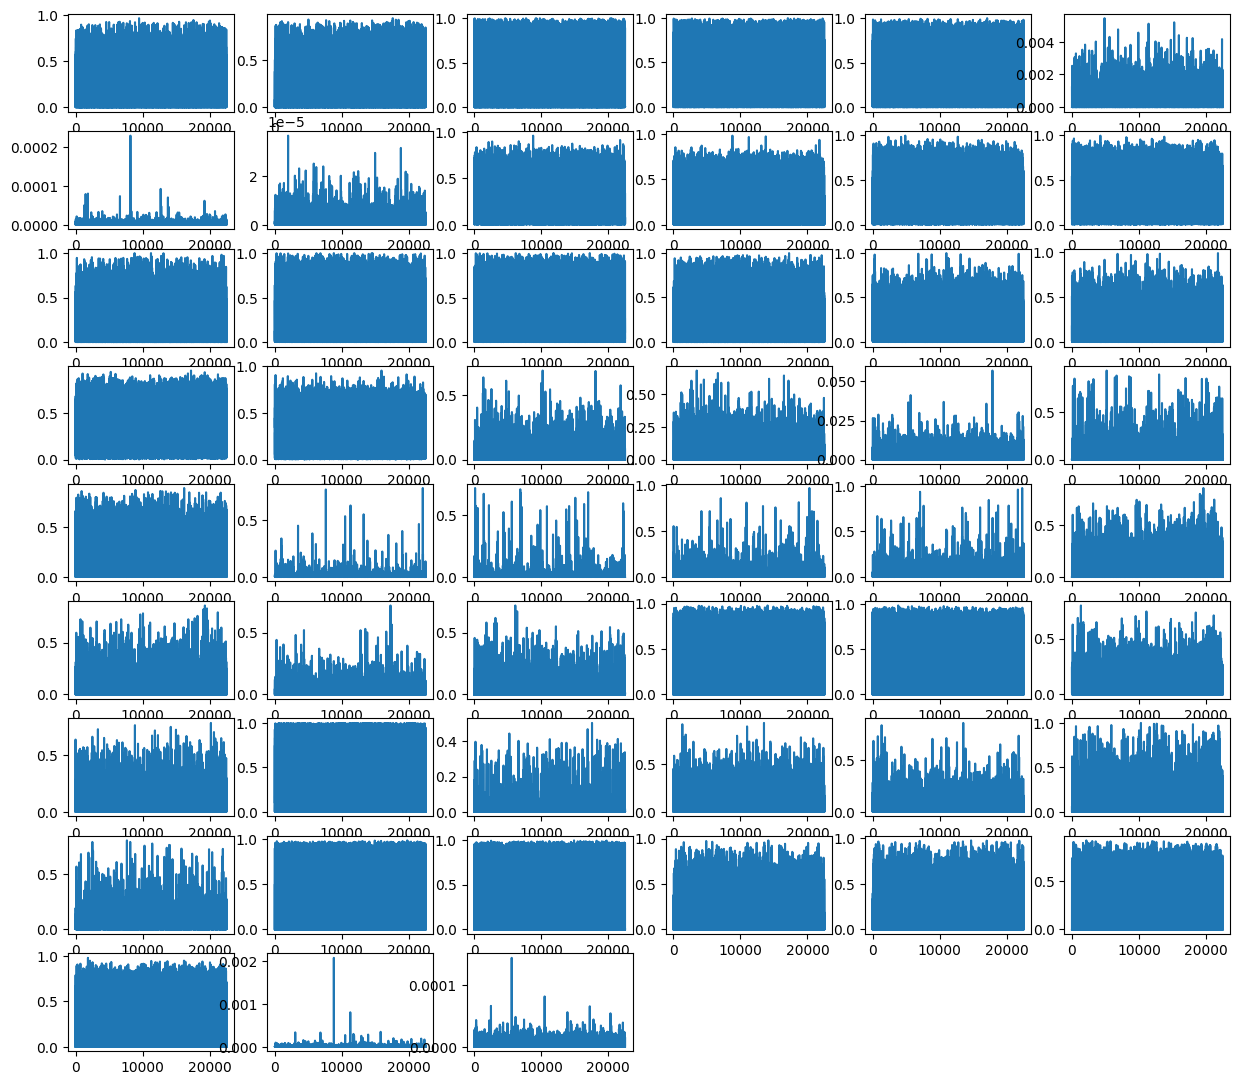

In [60]:
# load data for LSTM model

traindata = []
blend_set = []
labels_set = []
with open("blends_train_full_set.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  for line in csvFile:
    traindata.append(line[:])
  np.random.shuffle(traindata)
  for lines in traindata:
      blend_set.append(lines[0:52])
      labels_set.append(lines[52])
blends_set = np.array(blend_set, dtype=np.float64)
labels_set = np.array(labels_set, dtype=np.float64)
#Reshaping Array
X_train = np.reshape(blends_set, (22515, 52,1))
Y_train = np.reshape(labels_set, (22515,1)).astype('int')
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=3)
plt.figure(figsize = [15,15])
for i in range(1,52):
  plt.subplot(10,6,i)
  plt.plot(X_train[:,i])



# load validation data
valdata = []
val_blend_set = []
val_labels_set = []
with open("blends_val_full_set.csv", mode= "r") as val_data:
  csvFile = csv.reader(val_data)
  next(csvFile)
  for line in csvFile:
    valdata.append(line[:])
  np.random.shuffle(valdata)
  for lines in valdata:
      val_blend_set.append(lines[0:52])
      val_labels_set.append(lines[52])
val_blend_set = np.array(val_blend_set, dtype=np.float64)
val_labels_set = np.array(val_labels_set, dtype=np.float64)
X_val = np.reshape(val_blend_set, (1657, 52,1))
y_val = np.reshape(val_labels_set, (1657,1)).astype('int')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

# normalize data
# norm = tf.keras.layers.Normalization()
# norm.adapt(X_train)
# X_train = norm(X_train)
# X_train = np.array(X_train)

# norm.adapt(X_train)
# X_val = norm(X_val)
# X_val = np.array(X_val)

In [61]:
# keras tuner for LSTM model


# def build_model(hp):
  
#   learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-4, sampling="log")
#   layer_2 = hp.Int("l2", min_value=4, max_value=48, step=4)
#   layer_3 = hp.Int("l3", min_value=4, max_value=48, step=4)
#   kernel_r = hp.Float("kr", min_value=1e-10, max_value=0.0009, sampling="log")
#   acti_f = hp.Choice("af", ['relu', 'tanh', 'selu', 'leaky_relu'])

# # model structure
#   model = tf.keras.Sequential([
#       tf.keras.layers.LSTM(units = 52, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
#       tf.keras.layers.LSTM(units = layer_2, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)),
#       tf.keras.layers.LSTM(units = layer_3, activation = acti_f, return_sequences= False, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)),
#       tf.keras.layers.Dense(units = 3, activation = 'softmax'),
#   ])


  # model = tf.keras.Sequential([ 
  #     tf.keras.layers.Dense(units = 330, activation = 'relu', batch_input_shape = (64,33)),    
  #     tf.keras.layers.Dense(units = 300, activation = 'relu', kernel_regularizer='l2'),
  #     tf.keras.layers.Dropout(0.2),                         
  #     tf.keras.layers.Dense(units = 250, activation = 'relu', kernel_regularizer='l2'),                         
  #     tf.keras.layers.Dropout(0.2),                               
  #     tf.keras.layers.Dense(units = 220, activation = 'relu', kernel_regularizer='l2'),   
  #     tf.keras.layers.Dropout(0.2),                                                
  #     tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_regularizer='l2'), 
  #     tf.keras.layers.Dropout(0.2),                                                       
  #     tf.keras.layers.Dense(units = 150, activation = 'relu', kernel_regularizer='l2'), 
  #     tf.keras.layers.Dropout(0.2),                                                       
  #     tf.keras.layers.Dense(units = 10, activation = 'relu', kernel_regularizer='l2'),                         
  #     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
  # ])



# # Compiling the RNN
#   model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               optimizer= tf.keras.optimizers.Adam(learning_rate = learning_rate, global_clipnorm=1, amsgrad = True),
#               metrics = [tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score()])

#   return model 

# build_model(keras_tuner.HyperParameters())

# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     max_trials=30,
#     objective=keras_tuner.Objective('val_categorical_crossentropy', 'min'),
#     executions_per_trial=1,
#     overwrite=True,
#     directory="/home/samer/Desktop/Big data Small Data/BDSD/Minor_project/emotion_estimation/",
#     project_name="Emotion_estimation_tuning",
# )

# tuner.search_space_summary()

# tuner.search(x=X_train, y=Y_train, validation_data = (X_val,y_val), epochs=25, batch_size = 128)

# tuner.results_summary()



# EStop = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)


In [66]:
# LSTM model fitting

# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(units = 33, activation = 'relu', return_sequences= True),
#     tf.keras.layers.LSTM(units = 12, activation = 'relu', return_sequences= False),
#     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
# ])


# model = tf.keras.Sequential([ 
#     tf.keras.layers.Dense(units = 330, activation = 'relu', batch_input_shape = (64,33)),    
#     tf.keras.layers.Dense(units = 300, activation = 'relu', kernel_regularizer='l2'),
#     tf.keras.layers.Dropout(0.2),                         
#     tf.keras.layers.Dense(units = 250, activation = 'relu', kernel_regularizer='l2'),                         
#     tf.keras.layers.Dropout(0.2),                               
#     tf.keras.layers.Dense(units = 220, activation = 'relu', kernel_regularizer='l2'),   
#     tf.keras.layers.Dropout(0.2),                                                
#     tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_regularizer='l2'), 
#     tf.keras.layers.Dropout(0.2),                                                       
#     tf.keras.layers.Dense(units = 150, activation = 'relu', kernel_regularizer='l2'), 
#     tf.keras.layers.Dropout(0.2),                                                       
#     tf.keras.layers.Dense(units = 10, activation = 'relu', kernel_regularizer='l2'),                         
#     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
# ])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units = 52, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 16, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 48, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 44, activation = 'selu', return_sequences= False, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.Dense(units = 3, activation = 'softmax'),
])

# # Compiling the RNN
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#             optimizer= tf.keras.optimizers.Adam(learning_rate = 1.0955e-06, clipnorm=1),
#             metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score(), tf.keras.metrics.CategoricalCrossentropy()])

# best learning rate so far with 600 epochs Adam(learning_rate = 3.206e-05, global_clipnorm=1, use_ema=True, ema_momentum=0.99, amsgrad = True, beta_1=0.9, beta_2=0.999)

# model = tf.keras.saving.load_model("/ckpt/checkpoint.model.keras")

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer= tf.keras.optimizers.AdamW(learning_rate = 1.0955e-06, global_clipnorm=1, amsgrad = True),
            metrics = [tf.keras.metrics.CategoricalCrossentropy(),tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score()])

checkpoint_filepath = 'ckpt/epoch:{epoch:02d}-val_loss:{val_loss:.4f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 0)


EStop = tf.keras.callbacks.EarlyStopping(monitor="categorical_crossentropy", mode = 'min', min_delta= 0.0001, patience=10, restore_best_weights=True, verbose=0)

weight_for_0 = 1
weight_for_1 = 1
weight_for_2 = 1

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# # Fitting the RNN to the Training set
model.fit(x=X_train, y=Y_train, validation_data = (X_val,y_val) ,epochs = 100, batch_size=128, verbose=2, class_weight=class_weight )#callbacks=[model_checkpoint_callback, EStop])

Epoch 1/100
176/176 - 23s - loss: 1.1187 - categorical_crossentropy: 1.1184 - categorical_accuracy: 0.2777 - f1_score: 0.1450 - val_loss: 1.1179 - val_categorical_crossentropy: 1.1176 - val_categorical_accuracy: 0.1473 - val_f1_score: 0.0876 - 23s/epoch - 132ms/step
Epoch 2/100
176/176 - 20s - loss: 1.0907 - categorical_crossentropy: 1.0904 - categorical_accuracy: 0.3224 - f1_score: 0.2590 - val_loss: 1.0678 - val_categorical_crossentropy: 1.0674 - val_categorical_accuracy: 0.4387 - val_f1_score: 0.3273 - 20s/epoch - 114ms/step
Epoch 3/100
176/176 - 20s - loss: 1.0741 - categorical_crossentropy: 1.0738 - categorical_accuracy: 0.3948 - f1_score: 0.2789 - val_loss: 1.0291 - val_categorical_crossentropy: 1.0288 - val_categorical_accuracy: 0.6693 - val_f1_score: 0.3222 - 20s/epoch - 114ms/step
Epoch 4/100
176/176 - 19s - loss: 1.0641 - categorical_crossentropy: 1.0638 - categorical_accuracy: 0.4249 - f1_score: 0.2632 - val_loss: 1.0163 - val_categorical_crossentropy: 1.0160 - val_categoric

In [78]:
# evaluate
# model = tf.keras.models.load_model('LSTM_model_73%_test_acc')

test_blend_set = []
test_labels_set = []
with open("blends_test_set.csv", mode= "r") as test_data:
  csvFile = csv.reader(test_data)
  next(csvFile)
  for lines in csvFile:
      test_blend_set.append(lines[0:52])
      test_labels_set.append(lines[52])
test_blend_set = np.array(test_blend_set, dtype=np.float64)
test_labels_set = np.array(test_labels_set, dtype=np.float64).astype('int')
test_labels_set = tf.keras.utils.to_categorical(test_labels_set, num_classes=3)
X_test = np.reshape(test_blend_set, (1646, 52,1))

model.evaluate(X_test,test_labels_set)


# model.save('LSTM_model_full_data_acc:63_f1:55')

60/60 [==============================] - 1s 11ms/step - loss: 0.5957 - categorical_accuracy: 0.7335 - f1_score: 0.6905


[0.595723569393158,
 0.7335423231124878,
 array([0.88758093, 0.5116279 , 0.6722561 ], dtype=float32)]

In [80]:
# predict test classes
# new_model = tf.keras.models.load_model('LSTM_model_73%_test_acc')
predictions = []
for inst in X_test:
    inst = np.array(inst, dtype=np.float64)
    inst = np.reshape(inst, (1,52,1))
    # print(inst)
    y_pred = model.predict(inst, verbose=0)
    y_pred = np.argmax(y_pred)
    predictions.append(y_pred)
    # print(predictions)

In [ ]:
# confusion matrix

errors_count = {"0":0, "1":0, "2":0}
ground_truth = []
for i in test_labels_set:
    i = np.argmax(i)
    ground_truth.append(i)
cm=tf.math.confusion_matrix(ground_truth,predictions,num_classes=3,dtype=tf.dtypes.int32,)
print(cm)
for i in range(1646):
    if predictions[i]==ground_truth[i]:
        continue
    elif predictions[i] != ground_truth[i]:
        errors_count[str(ground_truth[i])] = errors_count[str(ground_truth[i])] + 1
print(errors_count)